In [1]:
import os
import random
import zipfile

from datasets import (
    load_dataset,
    load_from_disk,
    concatenate_datasets
)
from PIL import Image
from os.path import isfile, join
from tqdm.notebook import tqdm
from typing import List

In [2]:
def extract_data(root_dir: str | os.PathLike, output_dir: str | os.PathLike) -> None:
    os.makedirs(output_dir, exist_ok=True)

    with zipfile.ZipFile(root_dir, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

def gather_files(root_dir: str | os.PathLike) -> List[str]:
    return sorted([f for f in os.listdir(root_dir) if isfile(join(root_dir, f))])

def build_dataset(
    files_root_dir: str |  os.PathLike, 
    output_dir: str | os.PathLike,
    val_size: float = 0.05,
    test_size: float = 0.10,
    shuffle: bool = True,
    ) -> None:
    # Gathering files names
    imgs = gather_files(join(files_root_dir, "img"))
    masks = gather_files(join(files_root_dir, "mask"))
    names = [f.split('.')[0] for f in imgs]
    
    # Loading datasets 
    img_ds = load_dataset(path = join(files_root_dir, "img"), data_files = imgs)
    msks_ds = load_dataset(path = join(files_root_dir, "mask"), data_files = masks)
    
    # Adding name column & renaming label column
    img_ds['train'] = img_ds['train'].add_column('name', names)
    msks_ds = msks_ds.rename_column("image", "label")
    #img_ds = img_ds.rename_column("image", "pixel_values")

    # Merging into one dataset 
    img_ds['train'] = concatenate_datasets([img_ds['train'], msks_ds['train']], axis=1)

    # Splitting to train, dev and test sets 
    img_ds = img_ds['train'].train_test_split(test_size=val_size, shuffle=shuffle)
    val_ds = img_ds.pop("test")
    img_ds = img_ds['train'].train_test_split(test_size=test_size, shuffle=shuffle)
    img_ds["validation"] = val_ds

    # Saving to disk
    os.makedirs(f"{output_dir}", exist_ok=True)
    img_ds.save_to_disk(f"{output_dir}")


In [ ]:
zip_file_path = '/home/yassir/projects/image_semantic_segmentation/data/data.zip'
extract_directory = '/home/yassir/projects/image_semantic_segmentation/data/extracted'
extract_data(zip_file_path, extract_directory)

In [3]:
root_path = f"/home/yassir/projects/image_semantic_segmentation/data/extracted/"
ds_path = f"/home/yassir/projects/image_semantic_segmentation/data/processed/"
build_dataset(root_path, ds_path) 

Resolving data files:   0%|          | 0/22558 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22558 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/22558 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22558 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/9 shards):   0%|          | 0/19287 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2143 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1128 [00:00<?, ? examples/s]

In [4]:
ds = load_from_disk(ds_path)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'name', 'label'],
        num_rows: 19287
    })
    test: Dataset({
        features: ['image', 'name', 'label'],
        num_rows: 2143
    })
    validation: Dataset({
        features: ['image', 'name', 'label'],
        num_rows: 1128
    })
})

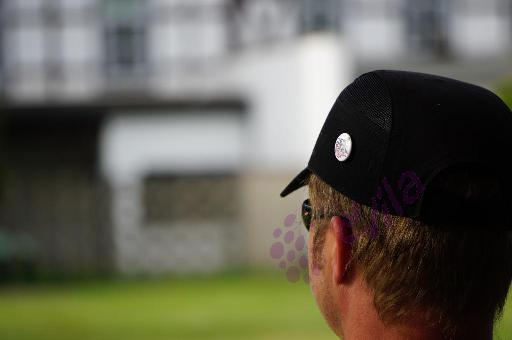

In [6]:
ds['train']['image'][111].convert("RGB")

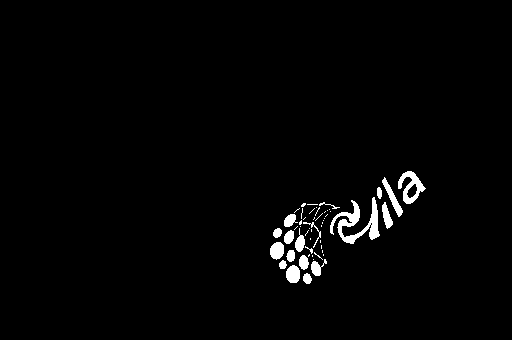

In [7]:
ds['train']['label'][111]